# Homework 7

Rixin Li & G . Besla

Filled out by Colton Quirk

In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
from tqdm import tqdm
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [15]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        """
        Initialize function for the analytical orbit class

        Inputs: filename, name of the file to store the orbit.
        """

        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### Store the output file name
        self.filename = filename

        # get the current pos/vel of M33 
        # create an instance of the  CenterOfMass class for M33
        # Using disk particles, ptype=2
        # store the position VECTOR of the M33 COM (.value to get rid of units)
        # store the velocity VECTOR of the M33 COM (.value to get rid of units)
        pos_M33, vel_M33 = self._compute_COM("M33_000.txt")

        # get the current pos/vel of M31 
        # create an instance of the  CenterOfMass class for M31
        # store the position VECTOR of the M31 COM (.value to get rid of units)
        # store the velocity VECTOR of the M31 COM (.value to get rid of units)
        pos_M31, vel_M31 = self._compute_COM("M31_000.txt")

        ### store the DIFFERENCE between the vectors posM33 - posM31
        # create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = pos_M33 - pos_M31
        self.v0 = vel_M33 - vel_M31
           
        ### get the mass of each component in M31 
        ### disk
        # self.rdisk = scale length (no units)
        self.rdisk = 5 # kpc

        # self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass('M31_000.txt', 2)*1e12 # ptype=2 are disk particles
        
        ### bulge
        # self.rbulge = set scale length (no units)
        self.rbulge = 1 # kpc

        # self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass('M31_000.txt', 3)*1e12 # ptype=3 are bulge particles
        
        # Halo
        # self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 61.60 # kpc from Assignment 5

        # self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass('M31_000.txt', 1)*1e12 # ptype=1 are halo particles

    def _compute_COM(self, filename, ptype=2, delta=0.1, volDec=2):
        COM = CenterOfMass(filename, ptype)
        pos = COM.COM_P(delta=delta, volDec=volDec)
        vel = COM.COM_V(*pos)
        return pos.value, vel.value

    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """
        Function to compute the gravitational acceleration induced by a Hernquist profile.
        This will be used for the acceleration due to the Bulge and Halo particles

        inputs:
            M: float
                Mass of something, Msun
            r_a: float
                Hernquist scale length, kpc
            r: vector
                Position vector of the gravitationally influenced object, kpc

        outputs:
            Hern: vector
                acceleration vector induced by the hernquist profile mass
        """
        
        ### Store the magnitude of the position vector
        r_mag = np.linalg.norm(r)
        
        ### Store the Acceleration
        Hern =  -r*self.G*M/(r_mag*(r_a+r_mag)**2) #The formula in the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern


    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """
        Function to compute the acceleration from the disk at far distances.
        This function uses the profile from Miyamoto-Nagai 1975.
        This will be used for the acceleration due to the disk particles

        Inputs:
            M: float
                Disk Mass, Msun
            r_d: float
                disk scale length, kpc
            r: vector
                position vector of the acceleratee

        Outputs:
            accel: vector
                gravitational acceleration vector
        """

        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        # the np.array allows for a different value for the z component of the acceleration

        x, y, z = r
        z_d = r_d/5.0

        R = np.sqrt(x*x + y*y)
        B = r_d + np.sqrt(z*z + z_d*z_d)

        ZSTUFF = B/np.sqrt(z*z + z_d*z_d)
        accel = -r*np.array([1, 1, ZSTUFF])*self.G*M/(R*R + B*B)**1.5

        return accel

    
    def M31Accel(self, r): # input should include the position vector, r
        """
        Function to compute the total acceleration from M31, from the disk
            bulge, and halo particles.

        Inputs:
            r: vector
                current position vector of M33

        Outputs:
            totalAccel: vector
                Total acceleration of M33 due to M31
        """

        ### Call the previous functions for the halo, bulge and disk
        # these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc.

        accelHalo = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        accelBulge = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        accelDisk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
            
        # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return accelHalo + accelBulge + accelDisk
    
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        Function to compute the next step in the LeapFrog integration algorithm.

        Inputs:
            dt: float
                size of timestep
            r: vector
                current position vector
            v: vector
                current velocity vector

        Outputs:
            rnew: vector
                position vector for the next step
            vnew: vector
                velocity vector for the next step
        """
        
        # predict the position at the next half timestep
        rhalf = r + 0.5 * dt * v
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position
        ahalf = self.M31Accel(rhalf)
        vnew = v + ahalf * dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + 0.5 * dt * vnew
        
        return rnew, vnew # return the new position and velocity vectors
    
    
    def OrbitIntegrator(self, t0, dt, tmax):
        """
        Function which integrates the orbit of M33 over time.

        Inputs:
            t0: float
                start time of the orbit
           dt: float
               timestep
           tmax: float
               end time of the simulation

        Outputs:
           Saves the orbit in a file
           Does not return a value
        """

        t_vals = np.arange(t0, tmax, dt)
        orbit = np.zeros((t_vals.shape[0], 7))
        
        r = self.r0
        v = self.v0
        for i, t in enumerate(tqdm(t_vals)):
            orbit[i] = t, *r, *v

            r, v = self.LeapFrog(dt, r, v)

        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
               .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function        

In [3]:
outfile = "M33OrbitAna.txt"

In [4]:
Orbit = M33AnalyticOrbit(filename=outfile)

In [10]:
t0 = 0 # Gyr
tmax = 10 # Gyr
dt = 1e-4 # Gyr
Orbit.OrbitIntegrator(t0=t0, dt=dt, tmax=tmax)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 25779.73it/s]


In [11]:
OrbitAna = np.genfromtxt(outfile, names=True)

In [12]:
r_mag = np.sqrt(OrbitAna['x']**2 + OrbitAna['y']**2 + OrbitAna['z']**2)
v_mag = np.sqrt(OrbitAna['vx']**2 + OrbitAna['vy']**2 + OrbitAna['vz']**2)

In [13]:
# Separation and Relative Velocity from Homework 6
orbit_M31 = np.genfromtxt('Orbit_M31.txt', names=True)
orbit_M33 = np.genfromtxt('Orbit_M33.txt', names=True)

orbit_M31_pos = np.column_stack((orbit_M31['x'], orbit_M31['y'], orbit_M31
                                 ['z']))
orbit_M31_vel = np.column_stack((orbit_M31['vx'], orbit_M31['vy'], orbit_M31['vz']))

orbit_M33_pos = np.column_stack((orbit_M33['x'], orbit_M33['y'], orbit_M33['z']))
orbit_M33_vel = np.column_stack((orbit_M33['vx'], orbit_M33['vy'], orbit_M33['vz']))

sep_M31_M33 = np.linalg.norm(orbit_M31_pos - orbit_M33_pos, axis=1)
vel_M31_M33 = np.linalg.norm(orbit_M31_vel - orbit_M33_vel, axis=1)

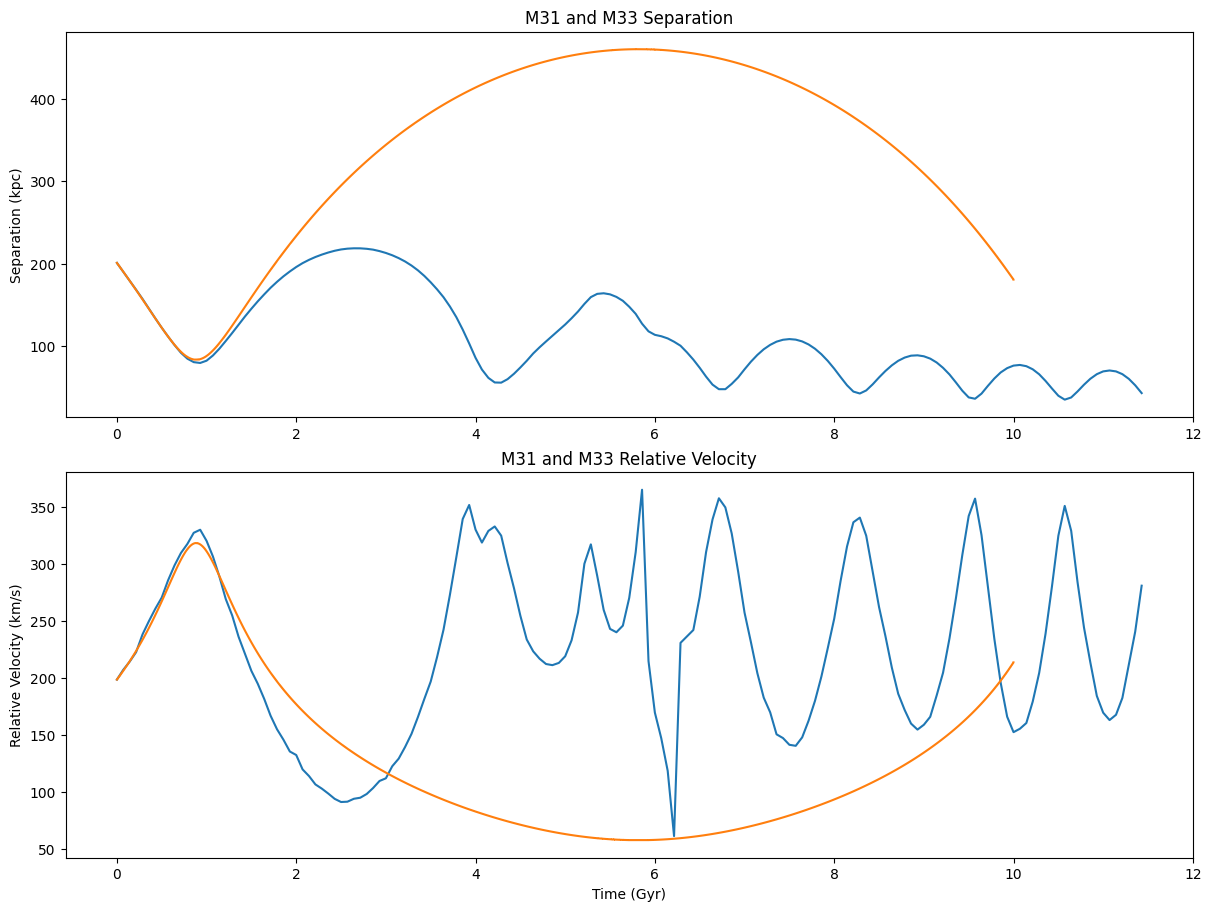

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9), layout='constrained')
ax[0].plot(orbit_M31['t'], sep_M31_M33)
ax[0].plot(OrbitAna['t'], r_mag)
ax[0].set_ylabel('Separation (kpc)')
ax[0].set_title('M31 and M33 Separation')

ax[1].plot(orbit_M31['t'], vel_M31_M33)
ax[1].plot(OrbitAna['t'], v_mag)
ax[1].set_ylabel('Relative Velocity (km/s)')
ax[1].set_xlabel('Time (Gyr)')
ax[1].set_title('M31 and M33 Relative Velocity')
plt.show()

# Questions

## 1. How do the plots compare?

They start off pretty similar and then diverge around $1Gyr$.

## 2. What missing physics could make the difference?

The assumptions in the acceleration calculations are that the particles are acting as a single point mass. This would ignore ffects of dynamical friction among other things.

## 3. The MW is missing in these calculates. How might you include its effects?

By incorporating the masses of its various components in the total acceleration function. You would do the same thing with the MW as was done with M31 and then add all the accelerations together.